In [1]:
import numpy as np 
import pandas as pd
import warnings
import eli5
import multiprocessing as mp
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sqlite3
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV

sns.set_palette('dark')
con = sqlite3.connect("fannie_mae_predictions.sqlite")
cur = con.cursor()
warnings.filterwarnings('ignore')



/Users/stephenhage/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/stephenhage/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Getting the Data
The API tool used a recursive script to fetch 20+ different comma-separated files from Github. They were downloaded locally and will be read into Pandas in a loop.

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)
dat_dir = "/Users/stephenhage/Github/National-File-B-Sample-File"
fileslist = list()
for file in os.listdir(dat_dir):
    if file.endswith(".zip"):
        if os.path.join(dat_dir, file) not in fileslist:
            fileslist.append(os.path.join(dat_dir, file))
        
dat_col_names = ["enterprise_flag", "record_num", "msa_code", "pct_minority", "income_ratio", "rent_affordability_cat", "mortgage_date", "loan_purpose", "fed_guarantee", "institution_type", "borrower_race", "coborrower_race", "borrower_gender", "coborrower_gender", "occupancy_code", "n_units", "unit_owner_occupied", "unit_affordability", "year"]
fileslist.sort()

The column `record_num` ought to be a unique identifier, but there are several repeated values. Just in case there are entire duplicated rows the `drop_duplicates()` function will be applied.

In [3]:
loans = pd.read_csv(fileslist[0], compression = 'zip', sep = ",", header = None, names = dat_col_names)
loans['datfile'] = fileslist[0]
for dat in fileslist[1:]:
    newdat = pd.read_csv(dat, compression = 'zip', sep = ",", header = None, names = dat_col_names)
    newdat['datfile'] = dat
    loans = loans.append(newdat, ignore_index = True)
    
loans = loans.drop_duplicates()


Many of the variables have a value of `9`, which represents either a missing value, an unknown value, or a not applicable value. It could be useful to count how many of these there are for each column.

In [4]:
## Missing values
for c in dat_col_names:
    print(c, ": ", len(loans[loans[c] == 9]))

enterprise_flag :  0
record_num :  20
msa_code :  0
pct_minority :  20819
income_ratio :  38979
rent_affordability_cat :  546563
mortgage_date :  118
loan_purpose :  192953
fed_guarantee :  0
institution_type :  0
borrower_race :  5743907
coborrower_race :  24994650
borrower_gender :  322530
coborrower_gender :  191676
occupancy_code :  0
n_units :  0
unit_owner_occupied :  0
unit_affordability :  3890622
year :  0


It may be worthwhile to plot the distributions as well, to see which variables have a particular skew.

[Text(0, 0.5, 'Occurrences'),
 Text(0.5, 0, 'Value'),
 Text(0.5, 1.0, 'Column unit_affordability')]

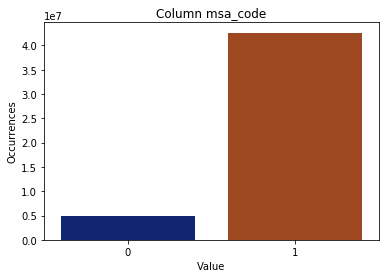

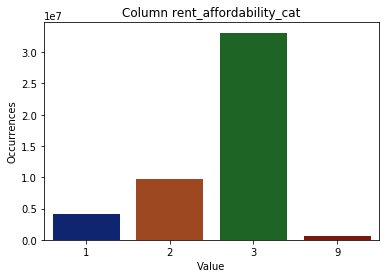

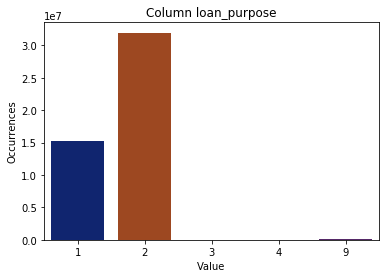

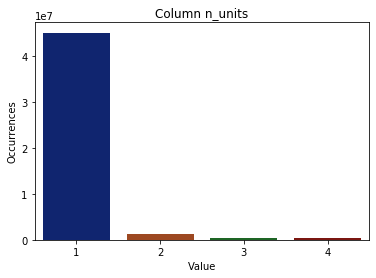

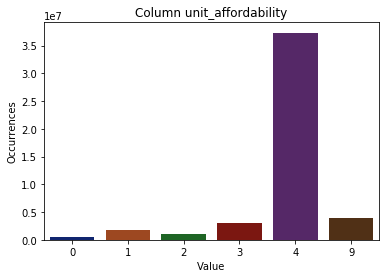

In [5]:
def plot_value_dist(col):
    plt_var = pd.DataFrame(loans[col].value_counts())
    plt.figure()
    outplt = sns.barplot(plt_var.index, plt_var[col]).set(title = f"Column {col}", xlabel = "Value", ylabel = "Occurrences")
    return outplt
    
# for c in loans.columns[2:-2]:
#     plot_value_dist(c)

plot_value_dist("msa_code")
plot_value_dist("rent_affordability_cat")
plot_value_dist("loan_purpose")
plot_value_dist("n_units")
plot_value_dist("unit_affordability")

There are a few variables that are exponentially distributed, namely `msa_code`, `rent_affordability_cat`, `loan_purpose`, `n_units` and `unit_affordability`. The bulk of loans are: 
* in urban areas
* lent to people making at least 80% of the median income in their area 
* for a home purchase or refinance
* single-unit
* not low-income or in a low-income area

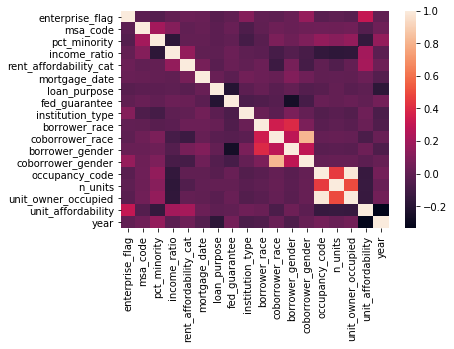

In [6]:
test_corr = loans[[c for c in loans.columns if c not in ['record_num']]].corr()
sns.heatmap(test_corr, annot = False)

Understanding that the values in this dataset are not ordinal, the actual correlation values can be taken with a grain of salt. This heat map, though, can be helpful in seeing which variables have relationships with which. For example, the number of units is strongly weakly related to the rent affordability category. Similarly, it appears that most coborrowers are the opposite sex of the borrower. This plot may help give guidance for model tweaking.

# Loan Data Exploratory Data Analysis

## Proportion of Fannie Mae Loans

In [7]:
round(len(loans.loc[loans.enterprise_flag == 1, 'enterprise_flag'].index)/len(loans.index), 2)

0.61

About 61% of all the loans in this dataset are with Fannie Mae, so as a baseline, models ought to correctly classify loans more than 61% of the time. 

The numeric labels are potentially confusing since they are not ordered (e.g. 1, 2, 3, 9). At the least, that obfuscates their meaning and may cause issues with modeling. When it comes time to build models the numbers will have to be encoded, but at this stage it makes more sense to use each value's meaning to understand the data we're working with.

One assumption that this analysis makes is that each record is valid. Without input from business or data stakeholders, we cannot dismiss observations even though they may violate intuition. For example, a single `record_num` having multiple loans in a single `year` seems unlikely, though that type of observation is prevalent in the dataset.

In [8]:
data_definitions = {
    "enterprise_flag": {1: "FannieMae",
                       2: "FreddieMac"},
    "msa_code": {0: "NonMetroArea",
                1: "MetroArea"},
    'pct_minority': {1: "<10%",
                    2: "<30%",
                    3: "<100%",
                    9: "Missing"},
     'income_ratio': {1: "<=80%",
                     2: "<=120%",
                     3: ">120%",
                     9: "Missing"},
     'rent_affordability_cat': {1: "<=50%",
                               2: "<=80%",
                               3: ">80%",
                               9: "Missing"},
     'mortgage_date': {1: "Originated in same calendar year as acquired",
                      2: "Originated prior to calendar year of acquisition",
                      9: "Missing"},
     'loan_purpose': {1: "Purchase",
                     2: "Refinancing",
                     3: "Second Mortgate",
                     4: "Home Improvement/Rehabilitation",
                      9: "N/A"},
     'fed_guarantee': {1: "FHA/VA",
                      2: "Rural Housing Service (RHS) - guaranteed rural housing loan",
                      3: "Home Equity Conversion Mortgage (HECM)",
                      4: "No Federal guarantee ",
                      5: "Title 1 – FHA"},
     'institution_type': {1: "Mortgage company",
                         2: "SAIF",
                         3: "BIF",
                         4: "NCUA",
                         5: "Other/Unknown"},
     'borrower_race': {1: "American Indian or Alaska Native",
                        2: "Asian",
                        3: "Black or African American",
                        4: "Native Hawaiian or Other Pacific Islander",
                        5: "White",
                        6: "Two or more races",
                        7: "Hispanic or Latino",
                        9: "N/A"},
     'coborrower_race': {1: "American Indian or Alaska Native",
                        2: "Asian",
                        3: "Black or African American",
                        4: "Native Hawaiian or Other Pacific Islander",
                        5: "White",
                        6: "Two or more races",
                        7: "Hispanic or Latino",
                        9: "N/A"},
     'borrower_gender': {1: "Male",
                         2: "Female",
                         3: "not provided",
                         4: "N/A",
                         9: "Missing"},
     'coborrower_gender': {1: "Male",
                             2: "Female",
                             3: "not provided",
                             4: "N/A Fannie Mae",
                             5: "N/A Freddie Mac",
                             9: "Missing"},
     'occupancy_code': {1: "Owner-occupied",
                        2: "Rental unit in an owner-occupied property",
                        3: "Investment property",
                        9: "N/A"},
     'n_units': {},
     'unit_owner_occupied': {1: "Yes",
                            2: "No"},
     'unit_affordability': {1: "Low-income family in a low- income area",
                            2: "Very low-income family in a low-income area",
                            3: "Very low-income family not in a low-income area",
                            4: "Other",
                            9: "N/A",
                            0: "Missing"},
}

for col in dat_col_names:
    if col not in ['year', 'record_num']:
        loans = loans.replace({col: data_definitions[col]})
        
loans.head()

,enterprise_flag,record_num,msa_code,pct_minority,income_ratio,rent_affordability_cat,mortgage_date,loan_purpose,fed_guarantee,institution_type,borrower_race,coborrower_race,borrower_gender,coborrower_gender,occupancy_code,n_units,unit_owner_occupied,unit_affordability,year,datfile
0,FreddieMac,1,MetroArea,<30%,>120%,<=80%,Originated in same calendar year as acquired,Purchase,No Federal guarantee,BIF,White,White,Male,Male,Investment property,1,No,N/A,2008,/Users/stephenhage/Github/National-File-B-Samp...
1,FreddieMac,2,MetroArea,<30%,>120%,>80%,Originated prior to calendar year of acquisition,Purchase,No Federal guarantee,Mortgage company,White,White,Female,Male,Owner-occupied,1,Yes,N/A,2008,/Users/stephenhage/Github/National-File-B-Samp...
2,FreddieMac,3,MetroArea,<10%,<=120%,>80%,Originated in same calendar year as acquired,Refinancing,No Federal guarantee,Mortgage company,White,White,Male,Female,Owner-occupied,1,Yes,N/A,2008,/Users/stephenhage/Github/National-File-B-Samp...
3,FreddieMac,4,MetroArea,<30%,>120%,>80%,Originated in same calendar year as acquired,Purchase,No Federal guarantee,SAIF,N/A,N/A,Male,N/A Freddie Mac,Owner-occupied,1,Yes,N/A,2008,/Users/stephenhage/Github/National-File-B-Samp...
4,FreddieMac,5,MetroArea,<30%,>120%,>80%,Originated prior to calendar year of acquisition,Refinancing,No Federal guarantee,BIF,N/A,N/A,Male,Female,Owner-occupied,1,Yes,N/A,2008,/Users/stephenhage/Github/National-File-B-Samp...


Having human-readable labels makes the meaning of each column much clearer, and potentially easier to use (or drop) in models.

## Proportions of Missing Values

In [9]:
n_rows = len(loans.index)
missing_vals = dict()
for col in loans.columns:
    missing_vals[col] = len(loans.loc[(loans[col] == "Missing") | (loans[col] == "N/A"), col].index)/n_rows
    
pd.DataFrame.from_dict(missing_vals, orient = "index", columns = ['pct_missing']).sort_values('pct_missing', ascending = False)

,pct_missing
coborrower_race,0.53
borrower_race,0.12
unit_affordability,0.09
rent_affordability_cat,0.01
borrower_gender,0.01
loan_purpose,0.00
coborrower_gender,0.00
income_ratio,0.00
pct_minority,0.00
mortgage_date,0.00


Missing values (or N/A's) could potentially be improved with imputation. In the original data, these were often (but not always) represented with the number `9`. Understanding where there may be data quality concerns will not only help our modeling now, but will make data collection and future accuracy all the better.

More than half of `coborrower_race` values are unknown, which makes sense given that it isn't mandatory to have a cosigner. We're also missing about 12% of values for `borrower_race`. This is a significant amount, and begs the question whether that is a field worth collecting. Our models may benefit from imputation on this variable. 

Beyond that, we are missing about 9% of values for `unit_affordability`, which would seem to be a highly-important predictor for loan risk; it may also be important for knowing which institution is the lender. We're also missing 1% of `borrower_gender` and `rend_affordability_cat`.

## Proportions of Fannie Mae Loans by Variable

In [10]:
coded_vars = ['msa_code', 'pct_minority','income_ratio', 'rent_affordability_cat', 'mortgage_date',
       'loan_purpose', 'fed_guarantee', 'institution_type', 'borrower_race',
       'coborrower_race', 'borrower_gender', 'coborrower_gender',
       'occupancy_code', 'n_units', 'unit_owner_occupied',
       'unit_affordability']
def var_rates(var):
    small_df = loans[["enterprise_flag", var, "record_num"]]
    varrate = small_df.groupby(["enterprise_flag", var]).count()
    varrate = varrate.groupby(level=0).apply(lambda x: x / float(x.sum()))
    return varrate.unstack()

for var in coded_vars:
    print(var_rates(var))


                record_num             
msa_code         MetroArea NonMetroArea
enterprise_flag                        
FannieMae             0.90         0.10
FreddieMac            0.89         0.11
                record_num                   
pct_minority          <10% <100% <30% Missing
enterprise_flag                              
FannieMae             0.29  0.33 0.39    0.00
FreddieMac            0.32  0.30 0.38    0.00
                record_num                    
income_ratio        <=120% <=80% >120% Missing
enterprise_flag                               
FannieMae             0.44  0.13  0.43    0.00
FreddieMac            0.45  0.12  0.43    0.00
                       record_num                   
rent_affordability_cat      <=50% <=80% >80% Missing
enterprise_flag                                     
FannieMae                    0.09  0.21 0.70    0.01
FreddieMac                   0.08  0.20 0.70    0.02
                record_num                                            

The variables that have the most proportional difference between Fannie Mae and Freddie Mac loans are `institution_type` (the Seller Institution) and `unit_affordability`. This ignores `coborrower_gender`, which has unique `N/A` values assigned to each lender. 

Most values are distributed about the same for each variable aside from these. The difference in `institution_type` is that Freddie Mac is almost 1.5 as likely to be a loan coming from a Bank Insured Fund (62% of the loans for Freddie Mac are BIF, vs. only 42% for Fannie Mae). Conversely, Fannie Mae is much more likely to buy loans from mortgage companies (45% to 32%), Savings Associated Insurance Fund institutions (7% to 4%), or Credit Unions (4% vs. 2%).

For `unit_affordability`, the major differences are that Freddie Mac has all the N/A (as opposed to Missing) values, whereas Fannie Mae has far more `Other` values. 

The variable `occupancy_code` is potentially interesting as well, though the differences are far more subtle than the previous examples. Fannie Mae has a higher rate of `Investment Property` mortgages (10% vs. 8%) where Freddie Mac has more `Owner-occupied` loans.

# Data Cleaning

It's tempting to use all the data available and jam it through some machine learning algorithm to make predictions. But we've seen that some fields are not consistent, namely race fields for the borrower and coborrower. There are also enough missing values to cast doubt on the usefulness of `unit_affordability`. This section will evalute each variable to see which may be used, which may be transformed, and which should be ignored. 

With tens of millions of observations, we only lose a sliver by ignoring missing values for most variables (outside of `coborrower_race`). Even `coborrower_race` has a description:

> "Category 9 includes mortgages for which no co-borrower race or ethnicity is identified, originally coded as information not provided by the co- borrower in a mail or telephone application, no co-borrower, not applicable, or not available."

Since there is uncertainty whether it is missing *or* not applicable, caution would dictate ignoring those observations.

We also created a column called `datfile` to denote which file was used to read the data. This was potentially useful for analyzing duplicate values or other oddities, but can safely be dropped.

In [12]:
loans = loans.drop("datfile", axis = 1)
loans = loans[loans["pct_minority"] != "Missing"] 
loans = loans[loans["income_ratio"] != "Missing"] 
loans = loans[loans["rent_affordability_cat"] != "Missing"]
loans = loans[loans["mortgage_date"] != "Missing"]
loans = loans[loans["unit_affordability"] != "Missing"] 
loans = loans[loans["institution_type"] != "Other/Unknown"] 
loans = loans[loans["coborrower_gender"] != "Missing"] 
loans.loc[(loans.coborrower_gender == "N/A Fannie Mae") | (loans.coborrower_gender == "N/A Freddie Mac"), "coborrower_gender"] = "N/A" # combine NA types as coborrower gender

loans.shape

(45888667, 19)

In [13]:
fannie_lns = loans.loc[loans.enterprise_flag == "FannieMae", ["record_num", "enterprise_flag"]].groupby("record_num", as_index = False).count()
freddie_lns = loans.loc[loans.enterprise_flag != "FannieMae", ["record_num", "enterprise_flag"]].groupby("record_num", as_index = False).count()
len(fannie_lns.merge(freddie_lns, on = "record_num", how = "inner").index)

2453842

After removing the problematic values, we are left with 45888667 records, 2453842 `record_num`s of which are listed under **both** Fannie Mae and Freddie Mac. This analysis will not use `record_num` for models nor as an identifier, based on the assumption that a given unit can have been purchased or refinanced with mortgages from multiple lenders.

## Unusable Variables

We've discussed the field `record_num` is simply a reference number and can likely be ignored safely. The prevalance of missing values for `coborrower_race` shows that it may actually be more useful to know whether there is a cosigner, rather than the different categories of race. That could be added as a flag, and tested to see whether `coborrower_race` could be safely removed.

This analysis will keep all values for these fields with the understanding that they may be useful for an internal audit. That way we can be sure there aren't biases in our lending process.

## Building Attributes
Since we have the same `record_num` multiple times, and `year` is a field, it may be useful to see when the last loan on the unit happened. It could also be useful to see what the most recent loan type was. For the analysis we will create attributes for 
* last year the unit had a loan
* the reason for the most recent previous loan
* the affordability category for the previous loan
* the last lending institution

In [14]:
loans['last_record_num'] = loans.record_num.shift(1)
loans['last_loan_yr'] = loans.year.shift(1)
loans['last_loan_reason'] = loans.loan_purpose.shift(1)
loans['change_in_unit_affordability'] = loans.unit_affordability.shift(1)
loans['last_lender'] = loans.enterprise_flag.shift(1)
loans.loc[loans.record_num != loans.last_record_num, ['last_record_num', 'last_loan_reason', 'change_in_unit_affordability', 'last_lender']] = "N/A"

loans.loc[loans.record_num != loans.last_record_num, "last_loan_yr"] = 0

loans = loans.drop(['record_num', 'last_record_num'], axis = 1)
loans.head()

,enterprise_flag,msa_code,pct_minority,income_ratio,rent_affordability_cat,mortgage_date,loan_purpose,fed_guarantee,institution_type,borrower_race,...,coborrower_gender,occupancy_code,n_units,unit_owner_occupied,unit_affordability,year,last_loan_yr,last_loan_reason,change_in_unit_affordability,last_lender
0,FreddieMac,MetroArea,<30%,>120%,<=80%,Originated in same calendar year as acquired,Purchase,No Federal guarantee,BIF,White,...,Male,Investment property,1,No,N/A,2008,0.00,N/A,N/A,N/A
1,FreddieMac,MetroArea,<30%,>120%,>80%,Originated prior to calendar year of acquisition,Purchase,No Federal guarantee,Mortgage company,White,...,Male,Owner-occupied,1,Yes,N/A,2008,0.00,N/A,N/A,N/A
2,FreddieMac,MetroArea,<10%,<=120%,>80%,Originated in same calendar year as acquired,Refinancing,No Federal guarantee,Mortgage company,White,...,Female,Owner-occupied,1,Yes,N/A,2008,0.00,N/A,N/A,N/A
3,FreddieMac,MetroArea,<30%,>120%,>80%,Originated in same calendar year as acquired,Purchase,No Federal guarantee,SAIF,N/A,...,N/A,Owner-occupied,1,Yes,N/A,2008,0.00,N/A,N/A,N/A
4,FreddieMac,MetroArea,<30%,>120%,>80%,Originated prior to calendar year of acquisition,Refinancing,No Federal guarantee,BIF,N/A,...,Female,Owner-occupied,1,Yes,N/A,2008,0.00,N/A,N/A,N/A


We want to preserve half the observations for out-of-sample testing, so we need to perform a random split the data now. That way we will have millions of unseen rows to test each model.

In [15]:
loan_train = loans.sample(frac = 0.5)
loan_train_y = loan_train.enterprise_flag
loan_test = loans.drop(loan_train.index)
loan_test_y = loan_test.pop("enterprise_flag")
loan_train.shape

(22944334, 22)

# Model Building

## Defining Success Metrics

Since Fannie Mae is the lending institution for about 61% of the records, there is a class imbalance to be considered. That imbalance is not enough to emphasize precision over accuracy, though it should be considered. Each model will be evaluated on test set accuracy and F1, which combines precision and recall measures.

This analysis also assumes that a false positive should be penalized more than a false negative, since it is likely more costly to try to do work with a loan that isn't owned by Fannie Mae than to miss an opportunity by wrongly believing a loan to originate with Freddie Mac.

Even "only" using half the data for training, we're still left with nearly 10mm rows, which is likely too much for a personal laptop to process. We will start with a small fraction of sampled observations and progressively sample more, until a representative set is obtained without taking inordinate time and memory.

## Starting Simple with Logistic Regression

### Code

In [16]:
X = loan_train.sample(frac = 0.5)
y = X.enterprise_flag
X = X.drop('enterprise_flag', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 416)

preprocess_pipe = Pipeline(steps = [('enc', OneHotEncoder(handle_unknown = "ignore"))])
lm_pipe = Pipeline(steps = [('preprocessor', preprocess_pipe),
                             ('classifier', LogisticRegression(max_iter=10000, 
                                                        tol = 0.1,
                                                       class_weight = {"FannieMae": .45,
                                                                       "FreddieMac": .55}))])
lm_pipe.fit(X_train, y_train)
lm_pred = lm_pipe.predict(X_test)

In [17]:
lm_acc = round(lm_pipe.score(X_test, y_test), 3)
lm_f1 = round(f1_score(y_test, lm_pred, average = 'weighted'), 3)

print(f"Logistic Regression had an accuracy of {lm_acc} and an F1 score of {lm_f1}")

Logistic Regression had an accuracy of 0.687 and an F1 score of 0.68


In [18]:
def get_pred_rates(preds): 
    X_test['preds'] = preds
    X_test['enterprise_flag'] = y_test
    fannie_pred_rt = round(float(len(X_test.loc[X_test.preds == "FannieMae", "preds"].index)/len(X_test.index)), 4)
    actual_rt = round(float(len(X_test.loc[X_test.enterprise_flag == "FannieMae", "enterprise_flag"].index)/len(X_test.index)), 4)
    return [fannie_pred_rt, actual_rt]
    
lm_rt, actl_rt = get_pred_rates(lm_pred)
f"Logistic Regression is predicting Fannie Mae {100*lm_rt}% of the time, vs an actual rate of {100*actl_rt}%"

'Logistic Regression is predicting Fannie Mae 68.35% of the time, vs an actual rate of 61.07%'

The output of a basic logistic regression is only slightly better than if we had guessed "Fannie Mae" for every row. It is, in fact, predicting "Fannie Mae" the majority of the time. A heat map help see the distribution of predictions vs. actual loan originators.

### Plots

#### Heat Map

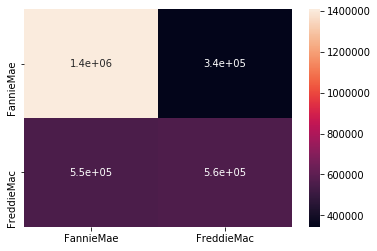

In [19]:
def make_heatmap(preds):
    labels = ["FannieMae", "FreddieMac"]
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot = True).set(yticklabels = labels, xticklabels = labels)

make_heatmap(lm_pred)

Logistic Regression does an admirable job of predicting Fannie Mae loans correctly, and has a relatively low False Positive rate. 

#### AUC

AUC: 0.6539363407369488


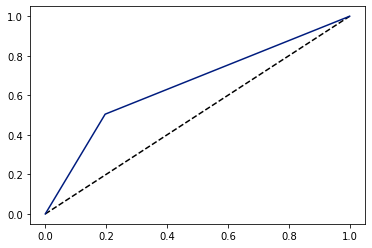

In [20]:
def auc_plot(preds):
    fpr, tpr, threshold = roc_curve(np.where(y_test == "FannieMae", 0, 1), 
                                         np.where(preds == "FannieMae", 0, 1))
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc}")
    plt.plot([0, 1], [0,1], 'k--')
    plt.plot(fpr, tpr)
    
fpr, tpr, threshold = roc_curve(np.where(y_test == "FannieMae", 0, 1), 
                                         np.where(lm_pred == "FannieMae", 0, 1))
lm_auc = auc(fpr, tpr)
auc_plot(lm_pred)

The area under the curve is only 0.65, so there is a lot of room for improvement. This model, though, was built primarily to serve as a low-cost baseline rather than a productionized model.

### Misclassification by Category
There is always risk when including variables (such as race and gender) which are also covered by legal protections. They shouldn't be automatically ignored, but their bias ought to be evaluated before any model is deployed. 

#### Bias Evaluation

In [21]:
def test_preds(var, preds):
    df = X_test
    df['preds'] = preds
    df['enterprise_flag'] = y_test
    df["correct_preds"] = np.where(df['preds'] == df['enterprise_flag'], 1, 0)
    df["incorrect_preds"] = np.where(df['preds'] != df['enterprise_flag'], 1, 0)
    summed_by_var = df[[var, 'preds','correct_preds', 'incorrect_preds']].groupby([var, 'preds']).sum()
    summed_by_var['correct_pred_rt'] = summed_by_var.correct_preds/(summed_by_var.correct_preds + summed_by_var.incorrect_preds)
    return summed_by_var
test_preds('borrower_race', lm_pred)


correct_preds  \
borrower_race                             preds                       
American Indian or Alaska Native          FannieMae            4269   
                                          FreddieMac            539   
Asian                                     FannieMae          101039   
                                          FreddieMac          28399   
Black or African American                 FannieMae           48518   
                                          FreddieMac          12360   
Hispanic or Latino                        FannieMae           93710   
                                          FreddieMac          29628   
N/A                                       FannieMae          186349   
                                          FreddieMac          53227   
Native Hawaiian or Other Pacific Islander FannieMae            4780   
                                          FreddieMac            781   
Two or more races                         FannieMae            2472   
                                          FreddieMac          17165   
White                                     FannieMae          965789   
                                          FreddieMac         421311   

                                                      incorrect_preds  \
borrower_race                             preds                         
American Indian or Alaska Native          FannieMae              1271   
                                          FreddieMac              335   
Asian                                     FannieMae             42241   
                                          FreddieMac            20431   
Black or African American                 FannieMae             17632   
                                          FreddieMac             8849   
Hispanic or Latino                        FannieMae             36430   
                                          FreddieMac            20531   
N/A                                       FannieMae             63543   
                                          FreddieMac            28199   
Native Hawaiian or Other Pacific Islander FannieMae              1491   
                                          FreddieMac              425   
Two or more races                         FannieMae               615   
                                          FreddieMac             2913   
White                                     FannieMae            390039   
                                          FreddieMac           262761   

                                                      correct_pred_rt  
borrower_race                             preds                        
American Indian or Alaska Native          FannieMae              0.77  
                                          FreddieMac             0.62  
Asian                                     FannieMae              0.71  
                                          FreddieMac             0.58  
Black or African American                 FannieMae              0.73  
                                          FreddieMac             0.58  
Hispanic or Latino                        FannieMae              0.72  
                                          FreddieMac             0.59  
N/A                                       FannieMae              0.75  
                                          FreddieMac             0.65  
Native Hawaiian or Other Pacific Islander FannieMae              0.76  
                                          FreddieMac             0.65  
Two or more races                         FannieMae              0.80  
                                          FreddieMac             0.85  
White                                     FannieMae              0.71  
                                          FreddieMac             0.62

Logistic regression has quite varied accuracy rates across the different races. While rates are high for American Indian and Two or more races, it had poor accuracy in classifying Freddie Mac loans across the board.

In [22]:
test_preds("borrower_gender", lm_pred)

correct_preds  incorrect_preds  correct_pred_rt
borrower_gender preds                                                      
Female          FannieMae          371812           149955             0.71
                FreddieMac         137033            94328             0.59
Male            FannieMae          922931           364868             0.72
                FreddieMac         393214           232711             0.63
Missing         FannieMae             614                1             1.00
                FreddieMac           1861              151             0.92
N/A             FannieMae            2804               90             0.97
                FreddieMac             21                0             1.00
not provided    FannieMae          108765            38348             0.74
                FreddieMac          31281            17254             0.64

With regard to gender, the accuracy rate was best when the value was `Missing`, `N/A` or `not provided`. The model performed better with Fannie Mae predictions than Freddie Mac, with roughly equal success for male and female applicants.

In [23]:
test_preds("rent_affordability_cat", lm_pred)

correct_preds  incorrect_preds  \
rent_affordability_cat preds                                        
<=50%                  FannieMae           92457            42774   
                       FreddieMac          50101            61725   
<=80%                  FannieMae          308938           109927   
                       FreddieMac         115687            53987   
>80%                   FannieMae         1005531           400561   
                       FreddieMac         397622           228732   

                                   correct_pred_rt  
rent_affordability_cat preds                        
<=50%                  FannieMae              0.68  
                       FreddieMac             0.45  
<=80%                  FannieMae              0.74  
                       FreddieMac             0.68  
>80%                   FannieMae              0.72  
                       FreddieMac             0.63

This model also had varied success with rent affordability. The model had better accuracy for predictions of "Fannie Mae" when the borrower's income was more than 50% of the local area's median. This model has some upward income bias that needs improvement, possibly by weighting predictions with other models.

In [24]:
test_preds("year", lm_pred)

correct_preds  incorrect_preds  correct_pred_rt
year preds                                                      
2008 FannieMae          173876            17892             0.91
     FreddieMac          93467              157             1.00
2009 FannieMae          215968            21079             0.91
     FreddieMac         129560              110             1.00
2010 FannieMae          106256            50993             0.68
     FreddieMac          67431            74101             0.48
2011 FannieMae          146414            74717             0.66
     FreddieMac          24278            24202             0.50
2012 FannieMae          234822           117503             0.67
     FreddieMac          11756            11466             0.51
2013 FannieMae          186644            91683             0.67
     FreddieMac          38192            38286             0.50
2014 FannieMae           78719            34763             0.69
     FreddieMac          42121            40231             0.51
2015 FannieMae           83269            43591             0.66
     FreddieMac          56157            48175             0.54
2016 FannieMae          100253            53673             0.65
     FreddieMac          52661            54815             0.49
2017 FannieMae           80705            47368             0.63
     FreddieMac          47787            52901             0.47

Finally, logistic regression had success with in predicting Fannie Mae loans in earlier years, correctly classifying 91% or more loans for 2008-2009. There appear to be deteriorating results for predictions in more recent years.

In [25]:
def get_feature_importance(pipe):
    pipe_feature_names = pipe.named_steps["preprocessor"].named_steps['enc'].get_feature_names()
    return eli5.explain_weights(pipe.named_steps["classifier"], top = 50, feature_names = pipe_feature_names)
get_feature_importance(lm_pipe)

Weight?,Feature
+11.335,x15_N/A
+4.604,x5_N/A
+2.758,x10_Missing
+2.638,x6_Rural Housing Service (RHS) - guaranteed rural housing loan
+2.252,x6_FHA/VA
+1.892,x5_Refinancing
+1.889,x9_Two or more races
+1.845,x5_Purchase
+1.775,x6_No Federal guarantee
+1.185,x3_>80%


#### Notes for Model Improvement

The purpose of starting with logistic regression was not to accurately classify all loans, but rather to set a baseline for all other models. Accuracy could be improved with a grid search on a few paramaters, but it is doubtful we could squeeze more than 5% more predictive power out of it. Testing several other classifiers may help narrow down which to tune in order to improve.

## Stochastic Gradient Descent

One may ask, "why use another linear model?". Stochastic Gradient Descent has potential for more tuning than Logistic Regression at low computational cost. It is worth pursuing to see if perhaps it will represent either an improvement in predictive accuracy, or if it might be sensitive to variables to which our other model was not. If the latter case, we may be able to use each model's predictions to synthesize an improved model. 

In [26]:
X = loan_train.sample(frac = 0.8)
y = X.enterprise_flag
X = X.drop('enterprise_flag', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 416)

preprocess_pipe = Pipeline(steps = [('enc', OneHotEncoder(handle_unknown = "ignore"))])
sgd_pipe = Pipeline(steps=[('preprocessor', preprocess_pipe),
                      ('classifier', SGDClassifier(n_jobs = -1, loss = "log", max_iter = 1000, early_stopping = True,
                                                  validation_fraction = .2))])


sgd_pipe.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('enc',
                                  OneHotEncoder(categories='auto', drop=None,
                                                dtype=<class 'numpy.float64'>,
                                                handle_unknown='ignore',
                                                sparse=True))],
                          verbose=False)),
                ('classifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=True, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='log',
                               max_iter=1000, n_iter_no_change=5, n_jobs=-1,
                               penalty='l2', power_t=0.5, random_state=None,
                               shuffle=True, tol=0.001,

In [27]:
sgd_pred = sgd_pipe.predict(X_test)
sgd_acc = round(sgd_pipe.score(X_test, y_test), 3)
sgd_f1 = round(f1_score(y_test, sgd_pred, average = 'weighted'), 3)
fpr, tpr, threshold = roc_curve(np.where(y_test == "FannieMae", 0, 1), 
                                         np.where(sgd_pred == "FannieMae", 0, 1))
sgd_auc = auc(fpr, tpr)

print(f"Stochastic Gradient Descent had an accuracy of {sgd_acc} and an F1 score of {sgd_f1}")

Stochastic Gradient Descent had an accuracy of 0.693 and an F1 score of 0.659


### Plots

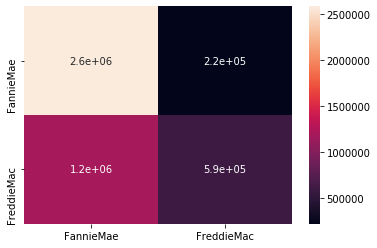

In [28]:
make_heatmap(sgd_pred)

SGD, oddly, had a higher rate of false negatives than did Logistic Regression. 

AUC: 0.6278187358002284


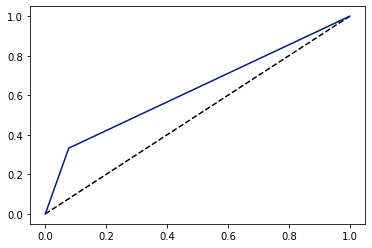

In [29]:
auc_plot(sgd_pred)

SGD did not represent an improvement over Logistic Regression on any of our metrics, though

In [30]:
get_feature_importance(sgd_pipe)

Weight?,Feature
+5.135,x15_N/A
+1.561,x9_Two or more races
+0.973,x10_Missing
+0.822,x7_BIF
+0.733,x5_Refinancing
+0.697,x5_Purchase
+0.625,x8_Two or more races
+0.609,x16_2015
+0.563,x16_2017
+0.544,x16_2016


SGD put the most weight on the housing `affordability_cat` variable, as the top predictor was having an `N/A` value. When the value was either `Other` or `Low-income family in a low-income area`, the weight is the lowest. 

We can interpret this as saying that our SGD model is most likely to classify a loan as "Fannie Mae" when there is an `N/A` value for `affordability_cat`, or when the `borrowers_race` was `Two or more races`. It is most likely to classify a loan as "Freddie Mac" when the loan originated between 2008-2009, or when the loan is for a low income family in a low-income area or `Other`.

### Misclassification by Category

In [31]:
test_preds('borrower_race', sgd_pred)

correct_preds  \
borrower_race                             preds                       
American Indian or Alaska Native          FannieMae            7193   
                                          FreddieMac            602   
Asian                                     FannieMae          181783   
                                          FreddieMac          29188   
Black or African American                 FannieMae           86711   
                                          FreddieMac          11744   
Hispanic or Latino                        FannieMae          171102   
                                          FreddieMac          29646   
N/A                                       FannieMae          329935   
                                          FreddieMac          57282   
Native Hawaiian or Other Pacific Islander FannieMae            8340   
                                          FreddieMac            885   
Two or more races                         FannieMae            4762   
                                          FreddieMac          27178   
White                                     FannieMae         1798790   
                                          FreddieMac         437079   

                                                      incorrect_preds  \
borrower_race                             preds                         
American Indian or Alaska Native          FannieMae              2404   
                                          FreddieMac              143   
Asian                                     FannieMae             83465   
                                          FreddieMac            11814   
Black or African American                 FannieMae             36004   
                                          FreddieMac             4556   
Hispanic or Latino                        FannieMae             77077   
                                          FreddieMac            11175   
N/A                                       FannieMae            130375   
                                          FreddieMac            13825   
Native Hawaiian or Other Pacific Islander FannieMae              2766   
                                          FreddieMac              146   
Two or more races                         FannieMae              1333   
                                          FreddieMac             3994   
White                                     FannieMae            856960   
                                          FreddieMac           170610   

                                                      correct_pred_rt  
borrower_race                             preds                        
American Indian or Alaska Native          FannieMae              0.75  
                                          FreddieMac             0.81  
Asian                                     FannieMae              0.69  
                                          FreddieMac             0.71  
Black or African American                 FannieMae              0.71  
                                          FreddieMac             0.72  
Hispanic or Latino                        FannieMae              0.69  
                                          FreddieMac             0.73  
N/A                                       FannieMae              0.72  
                                          FreddieMac             0.81  
Native Hawaiian or Other Pacific Islander FannieMae              0.75  
                                          FreddieMac             0.86  
Two or more races                         FannieMae              0.78  
                                          FreddieMac             0.87  
White                                     FannieMae              0.68  
                                          FreddieMac             0.72

In [32]:
test_preds('borrower_gender', sgd_pred)

correct_preds  incorrect_preds  correct_pred_rt
borrower_gender preds                                                      
Female          FannieMae          684758           317533             0.68
                FreddieMac         139983            60176             0.70
Male            FannieMae         1703131           792275             0.68
                FreddieMac         419322           148550             0.74
Missing         FannieMae            1102              782             0.58
                FreddieMac           2205               81             0.96
N/A             FannieMae            4498              101             0.98
                FreddieMac             34                7             0.83
not provided    FannieMae          195127            79693             0.71
                FreddieMac          32060             7449             0.81

In [33]:
test_preds('year', sgd_pred)

correct_preds  incorrect_preds  correct_pred_rt
year preds                                                      
2008 FannieMae          278160            28799             0.91
     FreddieMac         148768               39             1.00
2009 FannieMae          345532            33794             0.91
     FreddieMac         206965               68             1.00
2010 FannieMae          276361           176280             0.61
     FreddieMac          13527            12705             0.52
2011 FannieMae          261225           145832             0.64
     FreddieMac          12846            11768             0.52
2012 FannieMae          381195           192401             0.66
     FreddieMac          13984            13267             0.51
2013 FannieMae          346137           192523             0.64
     FreddieMac          15064            14013             0.52
2014 FannieMae          175975           104945             0.63
     FreddieMac          17554            14660             0.54
2015 FannieMae          155687            90051             0.63
     FreddieMac          68883            55895             0.55
2016 FannieMae          201504           119984             0.63
     FreddieMac          49935            47018             0.52
2017 FannieMae          166840           105775             0.61
     FreddieMac          46078            46830             0.50

## K-Nearest Neighbors
In addition to using linear models to classify the loans, we could benefit by using a distance-based "voting" method like K-Nearest Neighbors. This model is much more computationally intense than its linear counterparts, so even with parallel processing we will need to use a much smaller sample to train the model. We will look for accuracy, yes, but also differences in bias. For example, if KNN performs with better accuracy on recent loans, it may supplement weaknesses in our previous models. 

In [34]:
X = loan_train.sample(frac = 0.001)
y = X.enterprise_flag
X = X.drop('enterprise_flag', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 416)

preprocess_pipe = Pipeline(steps = [('enc', OneHotEncoder(handle_unknown = "ignore"))])
knn_pipe = Pipeline(steps = [('preprocessor', preprocess_pipe),
                            ('classifier',  KNeighborsClassifier(3, n_jobs = -1))])

knn_pipe.fit(X_train, y_train)
knn_pred = knn_pipe.predict(X_test)
knn_acc = round(knn_pipe.score(X_test, y_test), 3)
knn_f1 = round(f1_score(y_test, knn_pred, average = 'weighted'), 3)
fpr, tpr, threshold = roc_curve(np.where(y_test == "FannieMae", 0, 1), 
                                         np.where(knn_pred == "FannieMae", 0, 1))
knn_auc = auc(fpr, tpr)
print(f"KNN had an accuracy of {lm_acc} and an F1 score of {lm_f1}")

KNN had an accuracy of 0.687 and an F1 score of 0.68


In [35]:
knn_rt, actl_rt = get_pred_rates(knn_pred)
f"KNN Classifier is predicting Fannie Mae {knn_rt*100}% of the time, vs an actual rate of {actl_rt*100}%"

'KNN Classifier is predicting Fannie Mae 65.36% of the time, vs an actual rate of 61.419999999999995%'

### Plots

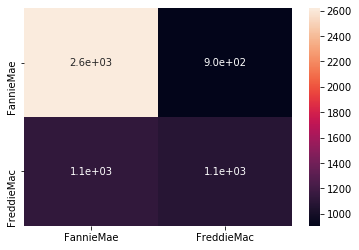

In [36]:
make_heatmap(knn_pred)

The F1 score improvement is telling; even on a very small sample we still have far fewer proportional false positive and false negative classifications. 

AUC: 0.6160228587582549


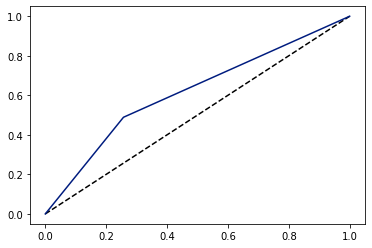

In [37]:
auc_plot(knn_pred)

The KNN model was a minor improvement on Logistic Regression despite being trained on a sample a fraction of the size. This was done because of intense compute time for the model, which could be improved with time to configure parallelization or distributed computing.

With a 69% accuracy rate it represents gains over previous models, though our secondary measures (F1 and AUC) suffer a bit. 

### Misclassification by Category

In [38]:
test_preds('borrower_race', knn_pred)

correct_preds  \
borrower_race                             preds                       
American Indian or Alaska Native          FannieMae              11   
                                          FreddieMac              2   
Asian                                     FannieMae             192   
                                          FreddieMac             46   
Black or African American                 FannieMae              90   
                                          FreddieMac             22   
Hispanic or Latino                        FannieMae             153   
                                          FreddieMac             55   
N/A                                       FannieMae             321   
                                          FreddieMac            107   
Native Hawaiian or Other Pacific Islander FannieMae               5   
                                          FreddieMac              0   
Two or more races                         FannieMae               6   
                                          FreddieMac             24   
White                                     FannieMae            1840   
                                          FreddieMac            826   

                                                      incorrect_preds  \
borrower_race                             preds                         
American Indian or Alaska Native          FannieMae                 5   
                                          FreddieMac                3   
Asian                                     FannieMae                69   
                                          FreddieMac               60   
Black or African American                 FannieMae                48   
                                          FreddieMac               29   
Hispanic or Latino                        FannieMae                73   
                                          FreddieMac               56   
N/A                                       FannieMae               128   
                                          FreddieMac               95   
Native Hawaiian or Other Pacific Islander FannieMae                 4   
                                          FreddieMac                5   
Two or more races                         FannieMae                 6   
                                          FreddieMac                1   
White                                     FannieMae               798   
                                          FreddieMac              656   

                                                      correct_pred_rt  
borrower_race                             preds                        
American Indian or Alaska Native          FannieMae              0.69  
                                          FreddieMac             0.40  
Asian                                     FannieMae              0.74  
                                          FreddieMac             0.43  
Black or African American                 FannieMae              0.65  
                                          FreddieMac             0.43  
Hispanic or Latino                        FannieMae              0.68  
                                          FreddieMac             0.50  
N/A                                       FannieMae              0.71  
                                          FreddieMac             0.53  
Native Hawaiian or Other Pacific Islander FannieMae              0.56  
                                          FreddieMac             0.00  
Two or more races                         FannieMae              0.50  
                                          FreddieMac             0.96  
White                                     FannieMae              0.70  
                                          FreddieMac             0.56

KNN produced much more variable accuracy by race, ranging from 37% to 95% by group. This is partially due to training on a small sample, but also reflects an insensitivity to `borrower_race`. This indicates that KNN, though it may not be the best model, may help the other models through weighting the predictions together.

## Random Forest

In [39]:
X = loan_train.sample(frac = 0.1)
y = X.enterprise_flag
X = X.drop('enterprise_flag', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 416)

preprocess_pipe = Pipeline(steps = [('enc', OneHotEncoder(handle_unknown = "ignore"))])
rf_pipe = Pipeline(steps = [('preprocessor', preprocess_pipe),
                            ('classifier',  RandomForestClassifier(3, n_jobs = -1))])

rf_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('enc',
                                  OneHotEncoder(categories='auto', drop=None,
                                                dtype=<class 'numpy.float64'>,
                                                handle_unknown='ignore',
                                                sparse=True))],
                          verbose=False)),
                ('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, m

In [40]:
rf_pred = rf_pipe.predict(X_test)
rf_acc = round(rf_pipe.score(X_test, y_test), 3)
rf_f1 = round(f1_score(y_test, rf_pred, average = 'weighted'), 3)
fpr, tpr, threshold = roc_curve(np.where(y_test == "FannieMae", 0, 1), 
                                         np.where(rf_pred == "FannieMae", 0, 1))
rf_auc = auc(fpr, tpr)
print(f"Random Forest had an accuracy of {rf_acc} and an F1 score of {rf_f1}")

Random Forest had an accuracy of 0.695 and an F1 score of 0.681


### Plots

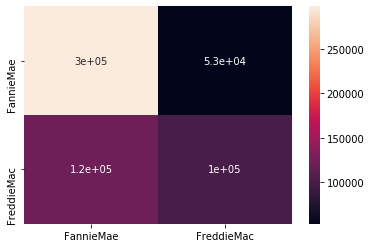

In [41]:
make_heatmap(rf_pred)


AUC: 0.6504347928047727


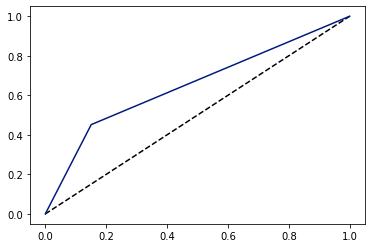

In [42]:
auc_plot(rf_pred)


Random Forest improves on all previous models on all three of our metrics (accuracy, F1, and AUC). This is true even though it was only trained on less than 10% of the training data. This is the most promising model thus far, and may be the best model to use given more computing resources in order to train and tune the model further.

In [43]:
rf_feature_names = rf_pipe.named_steps["preprocessor"].named_steps['enc'].get_feature_names()
eli5.explain_weights(rf_pipe.named_steps["classifier"], top = 25, feature_names = rf_feature_names[:79])


Weight,Feature
0.2669 ± 0.2473,x15_N/A
0.0770 ± 0.1487,x15_Other
0.0738 ± 0.0069,x16_2009
0.0486 ± 0.0067,x16_2008
0.0439 ± 0.0161,x7_Mortgage company
0.0380 ± 0.0127,x7_BIF
0.0151 ± 0.0093,x3_>80%
0.0145 ± 0.0142,x7_SAIF
0.0132 ± 0.0006,x16_2015
0.0131 ± 0.0083,x9_Two or more races


Random Forest puts the most weight on `Low-income family in a low-income area` and `N/A` for `affordability_cat`, meaning it is most likely to classify a given loan as "Fannie Mae" when those are the values. A major difference from the previous models is that it is more likely than not to classify as "Fannie Mae" a loan from 2008.

### Misclassification by Category

In [44]:
test_preds('borrower_race', rf_pred)

correct_preds  \
borrower_race                             preds                       
American Indian or Alaska Native          FannieMae             709   
                                          FreddieMac            149   
Asian                                     FannieMae           20718   
                                          FreddieMac           5421   
Black or African American                 FannieMae            9655   
                                          FreddieMac           2463   
Hispanic or Latino                        FannieMae           19110   
                                          FreddieMac           5402   
N/A                                       FannieMae           36913   
                                          FreddieMac          10974   
Native Hawaiian or Other Pacific Islander FannieMae             957   
                                          FreddieMac            218   
Two or more races                         FannieMae             826   
                                          FreddieMac           3393   
White                                     FannieMae          209151   
                                          FreddieMac          72544   

                                                      incorrect_preds  \
borrower_race                             preds                         
American Indian or Alaska Native          FannieMae               189   
                                          FreddieMac              168   
Asian                                     FannieMae              8637   
                                          FreddieMac             3446   
Black or African American                 FannieMae              3445   
                                          FreddieMac             1748   
Hispanic or Latino                        FannieMae              8087   
                                          FreddieMac             3475   
N/A                                       FannieMae             12252   
                                          FreddieMac             6183   
Native Hawaiian or Other Pacific Islander FannieMae               221   
                                          FreddieMac              174   
Two or more races                         FannieMae               232   
                                          FreddieMac              301   
White                                     FannieMae             88992   
                                          FreddieMac            37456   

                                                      correct_pred_rt  
borrower_race                             preds                        
American Indian or Alaska Native          FannieMae              0.79  
                                          FreddieMac             0.47  
Asian                                     FannieMae              0.71  
                                          FreddieMac             0.61  
Black or African American                 FannieMae              0.74  
                                          FreddieMac             0.58  
Hispanic or Latino                        FannieMae              0.70  
                                          FreddieMac             0.61  
N/A                                       FannieMae              0.75  
                                          FreddieMac             0.64  
Native Hawaiian or Other Pacific Islander FannieMae              0.81  
                                          FreddieMac             0.56  
Two or more races                         FannieMae              0.78  
                                          FreddieMac             0.92  
White                                     FannieMae              0.70  
                                          FreddieMac             0.66

Random Forest has less racial variance than previous models, though it predicts "Freddie Mac" loans especially poorly for American Indian, Native Hawaiian, and African-American borrowers. Conversely, it predicts with very good accuracy "Freddie Mac" loans for `Two or more races` and "Fannie Mae" for `Native Hawaiian` borrowers.

In [45]:
test_preds('borrower_gender', rf_pred)

correct_preds  incorrect_preds  correct_pred_rt
borrower_gender preds                                                      
Female          FannieMae           79652            33660             0.70
                FreddieMac          23113            13654             0.63
Male            FannieMae          196014            80994             0.71
                FreddieMac          70515            35592             0.66
Missing         FannieMae             161                9             0.95
                FreddieMac            351                3             0.99
N/A             FannieMae             562                5             0.99
                FreddieMac              9                5             0.64
not provided    FannieMae           21650             7387             0.75
                FreddieMac           6576             3697             0.64

This model also shows little bias between male and female borrowers, with roughly equal accuracy in classifying both genders. 

In [46]:
test_preds('year', rf_pred)

correct_preds  incorrect_preds  correct_pred_rt
year preds                                                      
2008 FannieMae           33062             2006             0.94
     FreddieMac          20152             1474             0.93
2009 FannieMae           41452             2184             0.95
     FreddieMac          27743             1876             0.94
2010 FannieMae           28544            15524             0.65
     FreddieMac           7950             7587             0.51
2011 FannieMae           28287            13677             0.67
     FreddieMac           6002             5860             0.51
2012 FannieMae           44545            20472             0.69
     FreddieMac           5198             5076             0.51
2013 FannieMae           38241            19246             0.67
     FreddieMac           6696             6994             0.49
2014 FannieMae           18032             9047             0.67
     FreddieMac           6305             5820             0.52
2015 FannieMae           18667            10710             0.64
     FreddieMac           9106             7356             0.55
2016 FannieMae           25170            14878             0.63
     FreddieMac           6695             6151             0.52
2017 FannieMae           22039            14311             0.61
     FreddieMac           4717             4757             0.50

Similar to previous models, RF had much higher accuracy on early records with deteriorating results on more recent loans. Interestingly, the dropoff in accuracy is far steeper than the others, moving from 90%+ accuracy in 2008-2009 to a 50% rate for "Freddie Mac" loans almost every year after.

### Gradient Boost

In [47]:
X = loan_train.sample(frac = 0.1)
y = X.enterprise_flag
X = X.drop('enterprise_flag', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 416)

preprocess_pipe = Pipeline(steps = [('enc', OneHotEncoder(handle_unknown = "ignore"))])


xg_pipe = Pipeline(steps = [('preprocessor', preprocess_pipe),
                            ('classifier',  GradientBoostingClassifier())])

xg_pipe.fit(X_train, y_train)



Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('enc',
                                  OneHotEncoder(categories='auto', drop=None,
                                                dtype=<class 'numpy.float64'>,
                                                handle_unknown='ignore',
                                                sparse=True))],
                          verbose=False)),
                ('classifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=No

In [48]:
xg_pred = xg_pipe.predict(X_test)
xg_acc = round(xg_pipe.score(X_test, y_test), 3)
xg_f1 = round(f1_score(y_test, xg_pred, average = 'weighted'), 3)
fpr, tpr, threshold = roc_curve(np.where(y_test == "FannieMae", 0, 1), 
                                         np.where(xg_pred == "FannieMae", 0, 1))
xg_auc = auc(fpr, tpr)
print(f"Gradient Boost had an accuracy of {xg_acc} and an F1 score of {xg_f1}")

Gradient Boost had an accuracy of 0.7 and an F1 score of 0.655


### Plots

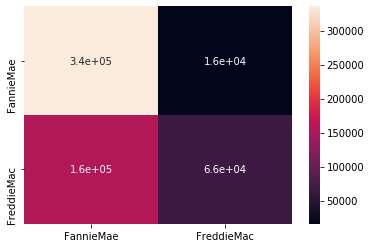

In [49]:
make_heatmap(xg_pred)


AUC: 0.6256559782737792


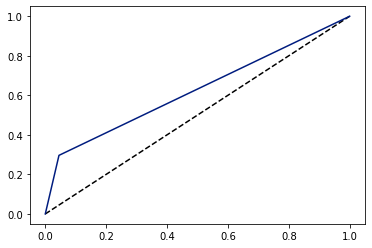

In [50]:
auc_plot(xg_pred)



Gradient Boost has the fastest initial climb on the AUROC plot, though the AUC is lower than for other models. We see that it has the highest accuracy, but also a relatively high rate of false negative predictions.

In [53]:
xg_feature_names = xg_pipe.named_steps["preprocessor"].named_steps['enc'].get_feature_names()
eli5.explain_weights(xg_pipe.named_steps["classifier"], top = 25, feature_names = xg_feature_names)

Weight,Feature
0.5343 ± 0.4299,x15_N/A
0.1341 ± 0.4003,x16_2009
0.1222 ± 0.1987,x7_BIF
0.0702 ± 0.1914,x16_2008
0.0405 ± 0.3082,x15_Other
0.0199 ± 0.1710,x9_Two or more races
0.0147 ± 0.2834,x7_SAIF
0.0092 ± 0.1477,x16_2012
0.0057 ± 0.1305,x16_2015
0.0052 ± 0.1304,x6_Home Equity Conversion Mortgage (HECM)


Similar to Random Forest, Gradient Boost picks up on the higher likelihood of a loan being with Fannie Mae when the `affordability_cat` is `Low-income family in a low-income area`. It also does so for a `Very low-income family not in a low-income area`, which is different from previous models. 

One other big difference is a high weighting of the variable `fed_guarantee`, where a value of `Title 1 - FHA` is more likely to be a Fannie Mae loan.

### Misclassification by Category

In [54]:
test_preds('borrower_race', xg_pred)

correct_preds  \
borrower_race                             preds                       
American Indian or Alaska Native          FannieMae             926   
                                          FreddieMac             79   
Asian                                     FannieMae           23520   
                                          FreddieMac           3115   
Black or African American                 FannieMae           11165   
                                          FreddieMac           1512   
Hispanic or Latino                        FannieMae           21905   
                                          FreddieMac           3414   
N/A                                       FannieMae           41962   
                                          FreddieMac           6889   
Native Hawaiian or Other Pacific Islander FannieMae            1062   
                                          FreddieMac            116   
Two or more races                         FannieMae             940   
                                          FreddieMac           3155   
White                                     FannieMae          234145   
                                          FreddieMac          47545   

                                                      incorrect_preds  \
borrower_race                             preds                         
American Indian or Alaska Native          FannieMae               279   
                                          FreddieMac               21   
Asian                                     FannieMae             10792   
                                          FreddieMac              547   
Black or African American                 FannieMae              4507   
                                          FreddieMac              394   
Hispanic or Latino                        FannieMae              9779   
                                          FreddieMac              871   
N/A                                       FannieMae             16880   
                                          FreddieMac             1139   
Native Hawaiian or Other Pacific Islander FannieMae               348   
                                          FreddieMac               31   
Two or more races                         FannieMae               369   
                                          FreddieMac              152   
White                                     FannieMae            113411   
                                          FreddieMac            12639   

                                                      correct_pred_rt  
borrower_race                             preds                        
American Indian or Alaska Native          FannieMae              0.77  
                                          FreddieMac             0.79  
Asian                                     FannieMae              0.69  
                                          FreddieMac             0.85  
Black or African American                 FannieMae              0.71  
                                          FreddieMac             0.79  
Hispanic or Latino                        FannieMae              0.69  
                                          FreddieMac             0.80  
N/A                                       FannieMae              0.71  
                                          FreddieMac             0.86  
Native Hawaiian or Other Pacific Islander FannieMae              0.75  
                                          FreddieMac             0.79  
Two or more races                         FannieMae              0.72  
                                          FreddieMac             0.95  
White                                     FannieMae              0.67  
                                          FreddieMac             0.79

GB has the highest floor of predictions by group, with the lowest-accuracy group being "Fannie Mae" loans for White applicants (67%). That was an average rate for other models! GB proves to be a little more insensitive to `borrower_race`, which is a factor in favor of it being the model of choice.

In [55]:
test_preds('borrower_gender', xg_pred)

correct_preds  incorrect_preds  correct_pred_rt
borrower_gender preds                                                      
Female          FannieMae           88422            40953             0.68
                FreddieMac          15948             4966             0.76
Male            FannieMae          221670           105070             0.68
                FreddieMac          45633            10067             0.82
Missing         FannieMae             132               51             0.72
                FreddieMac            337                6             0.98
N/A             FannieMae             555               22             0.96
                FreddieMac              4                1             0.80
not provided    FannieMae           24846            10269             0.71
                FreddieMac           3903              754             0.84

GB, like other models, performs with almost equal accuracy on male and female borrowers. 

In [56]:
test_preds('year', xg_pred)

correct_preds  incorrect_preds  correct_pred_rt
year preds                                                      
2008 FannieMae           34742             3470             0.91
     FreddieMac          18608               51             1.00
2009 FannieMae           43672             4158             0.91
     FreddieMac          25936               29             1.00
2010 FannieMae           35375            22607             0.61
     FreddieMac           1164              811             0.59
2011 FannieMae           33880            18769             0.64
     FreddieMac            907              517             0.64
2012 FannieMae           49098            24871             0.66
     FreddieMac            993              408             0.71
2013 FannieMae           44246            24277             0.65
     FreddieMac           1285              858             0.60
2014 FannieMae           21775            12447             0.64
     FreddieMac           2753             2238             0.55
2015 FannieMae           17983             9614             0.65
     FreddieMac          10311             8095             0.56
2016 FannieMae           29089            18287             0.61
     FreddieMac           2693             2035             0.57
2017 FannieMae           25765            17865             0.59
     FreddieMac           1175              752             0.61

Year continues to be a difficult variable to discern, since recent records perform much more poorly than early ones. The dropoff for GB is not as steep as for Random Forest, but after 2009 most years' accuracy is below 70%.

#### Notes for Model Improvement
GB is a candidate for big improvements with more computing resources, which would enable training on a much larger dataset than was possible on a local laptop.

# Model Selection

In [57]:
pd.DataFrame({"Logistic_Regression": {"Accuracy": lm_acc, "F1": lm_f1, "AUC": lm_auc},
              "SGD": {"Accuracy": sgd_acc, "F1": sgd_f1, "AUC": sgd_auc},
               "KNN": {"Accuracy": knn_acc, "F1": knn_f1, "AUC": knn_auc},
                "Random_Forest": {"Accuracy": rf_acc, "F1": rf_f1, "AUC": rf_auc},
                 "Gradient_Descent": {"Accuracy": xg_acc, "F1": xg_f1, "AUC": xg_auc}
                 })

,Logistic_Regression,SGD,KNN,Random_Forest,Gradient_Descent
Accuracy,0.69,0.69,0.65,0.69,0.70
F1,0.68,0.66,0.64,0.68,0.66
AUC,0.65,0.63,0.62,0.65,0.63


## Each Model's Blind Spots
None of the models vastly improved over our Logistic Regression benchmark. Gradient Boosting gained 1% in accuracy despite being trained on a sliver of the data of our linear models. This came at the cost of the F1 score.

All had worse results on loans after 2009 than before, which is of concern. While the linear models and KNN had varied results when broken down by race, the tree models (Random Forest and Gradient Boosting) were more robust to these differences.


## Further Considerations
This analysis was performed with about 45mm observations initially. Cleaning methods reduced that to about half. Some of that cleaning was necessary: 2mm records listed both lenders as the enterprise owning the loan. Other steps may have been extraneous, and given more time it may have been valuable to evaluate model performance including observation listed as `Missing` or `N/A`. That may hurt accuracy, but could allow processing of loan applications that contain missing values. A business decision would need to be made whether that tradeoff was worthwhile.

#### Further Feature Engineering
Though it wasn't mentioned in this write-up, models were initially tested on a fraction of the raw data. The best of these were barely more than 60% accurate. The `most-recent` features we created helped improve on that by as much as 10%. Creating more features, such as "number of previous loans" or "number of previous refinancing loans" may prove useful, as could a flag in the change in area poverty rates.

#### Dimensionality Reduction
Early tests with Principal Components Analysis did not yield substantive enough improvements over the base, cleaned data. In some datasets, pre-processing the data through orthoganal transforms can help make the decision to reduce dimensions, or at least to expedite model-building computations. This comes at the cost of obfuscating variables and their contribution to predictions. For this analysis, the tradeoffs were not acceptable and so PCA was not used.

#### More Compute Resources
This analysis was performed on a modern, powerful laptop (2018 MacBook Pro with 16GB of RAM). Yet, it took several minutes to train some models on small samples of the training set. This still represented hundreds of thousands of observations, but it was a huge limitation putting an upper bound on our accuracy. With additional time to configure GPU usage and optimization, or even training the models in the cloud, we could have used the full training set to improve our models.

#### Additional Data Sources
We achieved 70% accuracy with the models used, but that could undoubtedly be improved with access to more data sources. Having more observations may prove useful, but it could be invaluable to evaluate other metrics outside of this dataset. For example, there is undoubtedly a table with attributes of the borrower, of the unit's location, of rental occupancy rates, public transit, or other important factors. A much more robust approach to feature engineering using other facets of the lending relationship is likely the best source for improved model accuracy.

#### Ensembling the Models
Barring access to more data, each model run had strengths and weaknesses. Using a matrix optimization algorithm (such as Nelder-Mead) to weight predictions for each model on a validation data set could boost accuracy. For example, where Logistic Regression performed well on older records, Random Forest was adequate but had better accuracy recently. Furthermore, Logistic, KNN and Random Forest all are in different families of model, so blending their results through intelligent weighting may prove a 10% or more boon to our predictive power.

# Conclusion
No one model performed well on the train/test subset of the training data. Five models from three different "families" of modeling were developed. Each had different weights assigned to each variables, and each had their own biases. Some had different accuracy rates across genders and races. All struggled on records from recent loans. That is an indication that perhaps there were changes made in 2010 to laon policies, and additional data sources would help account for that. 

More compute resources and more business leader input would also help to further train the models. A 70% accuracy score is not ideal. Given these resources and time to tune the models would drastically improve accuracy scores.

Though each model similarly worsened on recent data, there were different features that each emphasized. If the business need for this model were to explain factor importance, logistic regression is the most straightforward to explain. For accuracy, letting the different models contribute their "voice" to the prediction may help improve performance. These are all saved in a sqlite database [link here](https://drive.google.com/open?id=1IQLtFTaNd0f8UXyrv3RR5fDYGLo8vB2j).

In [58]:
lm_test_pred = lm_pipe.predict_proba(loan_test)
sgd_test_pred = sgd_pipe.predict_proba(loan_test)
knn_test_pred = knn_pipe.predict_proba(loan_test)
rf_test_pred = rf_pipe.predict_proba(loan_test)
xg_test_pred = xg_pipe.predict_proba(loan_test)


In [59]:
lm_out = pd.DataFrame(lm_test_pred, columns = ['lm_fannie_mae', 'lm_fredde_mac'])
sgd_out = pd.DataFrame(sgd_test_pred, columns = ['sgd_fannie_mae', 'sgd_fredde_mac'])
knn_out = pd.DataFrame(knn_test_pred, columns = ['knn_fannie_mae', 'knn_fredde_mac'])
rf_out = pd.DataFrame(rf_test_pred, columns = ['rf_fannie_mae', 'rf_fredde_mac'])
xg_out = pd.DataFrame(xg_test_pred, columns = ['xg_fannie_mae', 'xg_fredde_mac'])
final_preds = pd.DataFrame()
final_preds['logistic_regression'] = lm_out['lm_fannie_mae']
final_preds['stochastic_gd'] = sgd_out['sgd_fannie_mae']
final_preds['knn'] = knn_out['knn_fannie_mae']
final_preds['random_forest'] = rf_out['rf_fannie_mae']
final_preds['gradient_boost'] = xg_out['xg_fannie_mae']
final_preds['final_pred'] = final_preds.mean(axis = 1)
final_preds['true_label'] = loan_test_y
final_preds[['final_pred', 'true_label']].to_sql('fanniemae', con)